In [98]:
pip install squarify

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import squarify

from google.colab import drive

# **PART 1: EDA**

In [100]:
ecommerce_df = pd.read_excel("/content/drive/MyDrive/D.A/Python/Final Project/ecommerce retail.xlsx", sheet_name="ecommerce retail")

In [101]:
ecommerce_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## **Check missing values, incorrect data, duplicates, outlier**
After check data, we have 6 problems which be dealt with later on
 1. `Quantity`, `UnitPrice` have many negative values
 2. `Description`, `CustomerID` have missing values (1454, 135080 respectively)
 3. `CustomerID` has incorrect datatype (float)
 4. `Description` has values in lowercase and uppercase disorderly
 5. 650 cases that 1 value in `StockCode` associates to more 2 different values in `Description`
 6. 3603 case that 1 value in `StockCode`associate to more 2 different values in `UnitPrice`, especially value in `UnitPrice` = 0 => prediction: price changes continuously so there are many difrent price; UnitPrice = 0 may refer to gift, price-pack

In [102]:
  # Overview
ecommerce_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


=> `CustomerID` has incorrect datatype (float) ==> convert into string

In [103]:
  # Count missing values
ecommerce_df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


=> `Description`, `CustomerID` have missing values (1454, 135080 respectively)

In [104]:
  # Check outliers: negative values, abnormal values
ecommerce_df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


=> `Quantity`, `UnitPrice` have many negative values

In [105]:
  # Check unique value
for i in ecommerce_df.select_dtypes('object').columns:
    print(i, ecommerce_df[i].unique())
    print('------------------------------------------------------------')

InvoiceNo [536365 536366 536367 ... 581585 581586 581587]
------------------------------------------------------------
StockCode ['85123A' 71053 '84406B' ... '90214U' '47591b' 23843]
------------------------------------------------------------
Description ['WHITE HANGING HEART T-LIGHT HOLDER' 'WHITE METAL LANTERN'
 'CREAM CUPID HEARTS COAT HANGER' ... 'lost'
 'CREAM HANGING HEART T-LIGHT HOLDER' 'PAPER CRAFT , LITTLE BIRDIE']
------------------------------------------------------------
Country ['United Kingdom' 'France' 'Australia' 'Netherlands' 'Germany' 'Norway'
 'EIRE' 'Switzerland' 'Spain' 'Poland' 'Portugal' 'Italy' 'Belgium'
 'Lithuania' 'Japan' 'Iceland' 'Channel Islands' 'Denmark' 'Cyprus'
 'Sweden' 'Austria' 'Israel' 'Finland' 'Bahrain' 'Greece' 'Hong Kong'
 'Singapore' 'Lebanon' 'United Arab Emirates' 'Saudi Arabia'
 'Czech Republic' 'Canada' 'Unspecified' 'Brazil' 'USA'
 'European Community' 'Malta' 'RSA']
------------------------------------------------------------


=> `Description` has values in lowercase and uppercase disorderly

In [106]:
  # Check duplicates: StockCode-Description
(ecommerce_df[["StockCode","Description"]].groupby("StockCode").nunique("Description") > 1).sum()

,0
Description,650


=> 650 cases that 1 value in `StockCode` associates to more 2 different values in `Description`

In [107]:
  # Check duplicates: InvoiceNo-CustomerID
(ecommerce_df[["InvoiceNo","CustomerID"]].groupby("InvoiceNo").nunique("CustomerID") > 1).sum()

,0
CustomerID,0


=> 1 `InvoiceNo` associate to only 1 `CustomerID`

In [108]:
  # Check duplicates: StockCode-UnitPrice
(ecommerce_df[["StockCode","UnitPrice"]].groupby("StockCode").nunique("UnitPrice") > 1).sum()

,0
UnitPrice,3603


=> 3603 case that 1 value in `StockCode`associate to more 2 different values in `UnitPrice`, especially value in `UnitPrice` = 0

## **Fix problems**

1. `Description` capitalize first character
2. `Description` fill 1454 missing values by values which have same value in `StockCode` + drop 185 lefting missing values (which can not be filled)

Example:  
  StockCode: 1 - Description: bycicle

  StockCode: 1 - Description: null => filling "bycicle"
  
3. `Description`: comply with the rule: 1 Descrition - 1 StockCode
4. `Quantity`, `UnitPrice`: drop negative values
5. `CustomerID` fill 135080 missing values, convert datatype into int

### **`Description`: capitalize first character + fill 1454 missing values + apply rule 1 StockCode - 1 Description**

In [109]:
df_clean = ecommerce_df.copy()
    # Capitalizing first character for values in Description
df_clean["Description"] = df_clean["Description"].str.capitalize()

In [110]:
    # Filling 1454 missing values
df_clean["Description"] = df_clean.groupby("StockCode")["Description"].ffill()
    # Remove 185 lefting missing values
df_clean = df_clean[df_clean["Description"].isnull() == False]

df_clean["Description"].isnull().sum()

0

In [111]:
    # Complying with the rule: 1 StockCode - 1 Description

# Step1: create dim_product table complying with the rule 1 StockCode - 1 Description
dim_product = df_clean[["StockCode","Description"]].groupby(["StockCode","Description"]).size().reset_index().sort_values(0,ascending=False).drop_duplicates("StockCode")

# Step2: map value from column dim_product["Description"] to column df_clean["Description"]
df_clean["Description"] = df_clean["StockCode"].map(dim_product.set_index("StockCode")["Description"])

# Step3: Check duplicates StockCode-Description
(df_clean[["StockCode","Description"]].groupby("StockCode").nunique("Description") > 1).sum()

,0
Description,0


=> Now, 1 `StockCode` associates to only 1 `Description`

### **`Quantity`, `UnitPrice`: remove negative values**

In [112]:
    # Remove negative values
df_clean = df_clean[(df_clean["Quantity"] >= 0) & (df_clean["UnitPrice"] >= 0)]
df_clean

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,White hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,White metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,Cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,Knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,Red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,Pack of 20 spaceboy napkins,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,Children's apron dolly girl,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,Childrens cutlery dolly girl,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,Childrens cutlery circus parade,4,2011-12-09 12:50:00,4.15,12680.0,France


### **`CustomerID`: fill 135080 missing values + conver datatype into int**
There are 2 ways to fill missing values:
1. Solution 1: based on `InvoiceNo`, **forward fill** CustomerID (1 InvoiceNo associates to only 1 CustomerID)
2. Solution 2: fill **fake CustomerID** (we assump that null value in CustomerID is one-time visitor - bought once => **fake CustomerID** only appear once)

**@ NOTE**: we should not remove missing values because the number of missing values is too large, that can affect segment result

In [113]:
    # Check rule whether or not 1 InvoiceNo associates to many CustomerID
pivot = df_clean.groupby("InvoiceNo").agg({"CustomerID": "nunique"}).rename(columns={"CustomerID":"count_customerid"}).reset_index()
(pivot["count_customerid"]> 1).sum()

0

=> 1 InvoiceNo associates to only 1 CustomerID

In [114]:
    # Solution 1: forward fill CustomerID based on InvoiceNo
df_clean["CustomerID"] = df_clean.groupby("InvoiceNo")["CustomerID"].ffill()
df_clean["CustomerID"].isnull().sum()

133303

=> The number of missing values in CustomerID does not change => we can not fill CustomerID based on InvoiceNo

=> We will use solution 2 - fill fake CustomerID

In [115]:
    # Create array including values in InvoiceNo which have missing values in CustomerID
null_customerid = df_clean[df_clean["CustomerID"].isnull()]["InvoiceNo"].unique()
null_customerid

array([536414, 536544, 536555, ..., 581492, 581497, 581498], dtype=object)

In [116]:
    # Fill fake CustomerID

# Find max value in CustomerID in order to fill fake CustomerID => lead to no duplicates
m = int(max(df_clean["CustomerID"]))

# Create dim series_cus: index = InvoiceNo, value = fake CustomerID. This table complies with the rule: 1 InvoiceNo - 1 CustomerID
series_cus = pd.Series(
    range(m+1, m+1+len(null_customerid))
    , index = null_customerid
)

''' Map value from series_cus to column InvoiceNo in df
(Note: only select values in InvoiceNo which have CustomerID included in array null_customerid. If not, the left values (not included in array null_customerid) in CustomerID will be null) '''
df_clean.loc[df_clean["InvoiceNo"].isin(null_customerid),"CustomerID"] = df_clean["InvoiceNo"].map(series_cus)

# Check missing values in CustomerID
df_clean["CustomerID"].isnull().sum()

0

=> DONE filling all missing values by fake CustomerID

In [117]:
    # Convert datatype into int
df_clean["CustomerID"] = df_clean["CustomerID"].astype(int)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 531227 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    531227 non-null  object        
 1   StockCode    531227 non-null  object        
 2   Description  531227 non-null  object        
 3   Quantity     531227 non-null  int64         
 4   InvoiceDate  531227 non-null  datetime64[ns]
 5   UnitPrice    531227 non-null  float64       
 6   CustomerID   531227 non-null  int64         
 7   Country      531227 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 52.6+ MB


## **Done EDA**
=> After cleaning data, we have:
1. All columns have correct datatype
2. No missing values in any columns

# **PART 2: SEGMENTATION**
Because I do not have sense in this field, dataset is divided into 5 parts by **quintile** (basic method)

5 is the highest score corresponding to positive things, in contrast 1 is the lowest score corresponding to negative things

In [118]:
df_enriched = df_clean.copy()

In [119]:
df_enriched["Rev"] = df_enriched["Quantity"] * df_enriched["UnitPrice"]
df_enriched.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Rev
0,536365,85123A,White hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,White metal lantern,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,Cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,Knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,Red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


### **Recency**: This refers to the time elapsed since the most recent activity, compared to December 31, 2011.

- *5 points*: made a purchase within **first** quintile day
- *4 points*: made a purchase within **second** quintile day
- *3 points*: made a purchase within **third** quintile day
- *2 points*: made a purchase within **fourth** quintile day
- *1 point*: else

In [120]:
  # Recency
pivot_re = df_enriched.groupby("CustomerID").agg({"InvoiceDate": "max"}).reset_index()
pivot_re["CurrDate"] = "2011-12-31"
pivot_re["CurrDate"] = pd.to_datetime(pivot_re["CurrDate"])
pivot_re["Recency"] = (pivot_re["CurrDate"] - pivot_re["InvoiceDate"]).dt.days

# Sort values DayDiff descending
pivot_re.sort_values("Recency", ascending=False)

,CustomerID,InvoiceDate,CurrDate,Recency
1038,13747,2010-12-01 10:37:00,2011-12-31,394
2629,15922,2010-12-01 13:51:00,2011-12-31,394
1323,14142,2010-12-01 16:33:00,2011-12-31,394
1393,14237,2010-12-01 13:20:00,2011-12-31,394
4342,18291,2010-12-01 14:48:00,2011-12-31,394
...,...,...,...,...
3754,17490,2011-12-09 09:08:00,2011-12-31,21
3137,16626,2011-12-09 11:56:00,2011-12-31,21
550,13069,2011-12-09 08:39:00,2011-12-31,21
2462,15694,2011-12-09 09:44:00,2011-12-31,21


In [121]:
  # qcut
re_category, re_array = pd.qcut(pivot_re["Recency"], q=5, labels=["Q1", "Q2", "Q3", "Q4","Q5"], retbins=True)
print(re_array)

  # np.select
conditions_re =[
    pivot_re["Recency"] <= re_array[1]
    , pivot_re["Recency"] <= re_array[2]
    , pivot_re["Recency"] <= re_array[3]
    , pivot_re["Recency"] <= re_array[4]
    , pivot_re["Recency"] <= re_array[5]
]

choices_re = [5,4,3,2,1]
pivot_re["R_score"] = np.select(conditions_re, choices_re)
pivot_re.head()

[ 21.  39.  73. 147. 260. 394.]


,CustomerID,InvoiceDate,CurrDate,Recency,R_score
0,12346,2011-01-18 10:01:00,2011-12-31,346,1
1,12347,2011-12-07 15:52:00,2011-12-31,23,5
2,12348,2011-09-25 13:13:00,2011-12-31,96,3
3,12349,2011-11-21 09:51:00,2011-12-31,39,5
4,12350,2011-02-02 16:01:00,2011-12-31,331,1


### **Frequency**: This refers to the total number of orders placed by the customer.

- *5 points*: else
- *4 points*: total number of orders ranges from **fourth** quintile
- *3 points*: total number of orders ranges from **third** quintile
- *2 points*: total number of orders ranges from **second** quintile
- *1 point*: total number of orders ranges from **first** quintile

In [122]:
   # Frequency
pivot_fre = df_enriched.groupby("CustomerID").agg({"InvoiceNo":"nunique"}).sort_values("InvoiceNo", ascending=True).reset_index().reset_index().rename(columns={"InvoiceNo":"Frequency","index":"Rank"})

# qcut
fre_category, fre_array = pd.qcut(pivot_fre["Rank"], q=5, labels=["Q1", "Q2", "Q3", "Q4","Q5"], retbins=True)
print(fre_array)

# np.select
conditions_fre =[
    pivot_fre["Rank"] <= fre_array[1]
    , pivot_fre["Rank"] <= fre_array[2]
    , pivot_fre["Rank"] <= fre_array[3]
    , pivot_fre["Rank"] <= fre_array[4]
    , pivot_fre["Rank"] <= fre_array[5]
]
choices_fre = [1,2,3,4,5]
pivot_fre["F_score"] = np.select(conditions_fre, choices_fre)

pivot_fre.head()

[   0.  1294.4 2588.8 3883.2 5177.6 6472. ]


,Rank,CustomerID,Frequency,F_score
0,0,12346,1,1
1,1,18626,1,1
2,2,18625,1,1
3,3,18624,1,1
4,4,18623,1,1


### **Monetary**: This refers to the total revenue generated by the customer.

- *5 points*: else
- *4 points*: total revenue generated ranges from **fourth** quintile
- *3 points*: total revenue generated ranges from **third** quintile
- *2 points*: total revenue generated ranges from **second** quintile
- *1 point*: total revenue generated ranges from **first** quintile

In [123]:
  # Monetary
pivot_mon = df_enriched.groupby("CustomerID").agg({"Rev":"sum"}).reset_index().sort_values("Rev", ascending=False).rename(columns={"Rev":"Monetary"})

# qcut
mon_category, mon_array = pd.qcut(pivot_mon["Monetary"], q=5, labels=["Q1", "Q2", "Q3", "Q4","Q5"], retbins=True)
print(mon_array)

# np.select
conditions_mon =[
    pivot_mon["Monetary"] <= mon_array[1]
    , pivot_mon["Monetary"] <= mon_array[2]
    , pivot_mon["Monetary"] <= mon_array[3]
    , pivot_mon["Monetary"] <= mon_array[4]
    , pivot_mon["Monetary"] <= mon_array[5]
]
choices_mon =[1,2,3,4,5]
pivot_mon["M_score"] = np.select(conditions_mon, choices_mon)
pivot_mon.head()

[0.0000000e+00 7.0412000e+01 3.3265600e+02 7.4891600e+02 1.7987100e+03
 2.8020602e+05]


,CustomerID,Monetary,M_score
1690,14646,280206.02,5
4202,18102,259657.30,5
3729,17450,194550.79,5
3009,16446,168472.50,5
1880,14911,143825.06,5


### **RFM score**

In [124]:
seg_table = pivot_re[["CustomerID","Recency","R_score"]].merge(pivot_fre[["CustomerID","Frequency","F_score"]], on="CustomerID") \
                                  .merge(pivot_mon[["CustomerID","Monetary","M_score"]], on="CustomerID")
seg_table.head()

,CustomerID,Recency,R_score,Frequency,F_score,Monetary,M_score
0,12346,346,1,1,1,77183.60,5
1,12347,23,5,7,5,4310.00,5
2,12348,96,3,4,4,1797.24,4
3,12349,39,5,1,3,1757.55,4
4,12350,331,1,1,3,334.40,3


In [125]:
seg_table["RFM_score"] = seg_table["R_score"].astype(str) + seg_table["F_score"].astype(str) + seg_table["M_score"].astype(str)
seg_table["RFM_score"] = seg_table["RFM_score"].astype(int)
seg_table.head()

,CustomerID,Recency,R_score,Frequency,F_score,Monetary,M_score,RFM_score
0,12346,346,1,1,1,77183.60,5,115
1,12347,23,5,7,5,4310.00,5,555
2,12348,96,3,4,4,1797.24,4,344
3,12349,39,5,1,3,1757.55,4,534
4,12350,331,1,1,3,334.40,3,133


### **Segmenting customer**
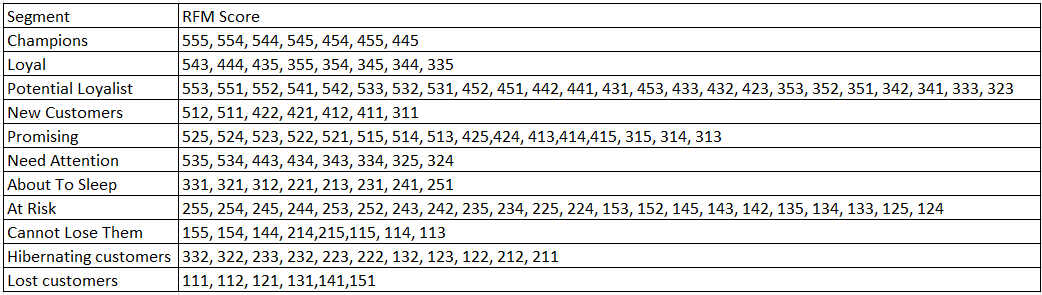

In [126]:
champions = pd.Series("Champions", index=[555, 554, 544, 545, 454, 455, 445])
loyal = pd.Series("Loyal", index=[543, 444, 435, 355, 354, 345, 344, 335])
potential = pd.Series("Potential Loyalist", index=[553, 551, 552, 541, 542, 533, 532, 531, 452, 451, 442, 441, 431, 453, 433, 432, 423, 353, 352, 351, 342, 341, 333, 323])
new = pd.Series("New Customers", index=[512, 511, 422, 421, 412, 411, 311])
promising= pd.Series("Promising", index=[525, 524, 523, 522, 521, 515, 514, 513, 425,424, 413,414,415, 315, 314, 313])
need = pd.Series("Need Attention", index=[535, 534, 443, 434, 343, 334, 325, 324])
sleep = pd.Series("About To Sleep", index=[331, 321, 312, 221, 213, 231, 241, 251])
risk = pd.Series("At Risk", index=[255, 254, 245, 244, 253, 252, 243, 242, 235, 234, 225, 224, 153, 152, 145, 143, 142, 135, 134, 133, 125, 124])
not_lose = pd.Series("Cannot Lose Them", index=[155, 154, 144, 214,215,115, 114, 113])
hiber = pd.Series("Hibernating customers", index=[332, 322, 233, 232, 223, 222, 132, 123, 122, 212, 211])
lost = pd.Series("Lost customers", index=[111, 112, 121, 131,141,151])

# Create summay series to map values to dataframe
sumary_series = pd.concat([champions, loyal, potential, new, promising, need, sleep, risk, not_lose, hiber, lost], axis=0)
sumary_series

,0
555,Champions
554,Champions
544,Champions
545,Champions
454,Champions
...,...
112,Lost customers
121,Lost customers
131,Lost customers
141,Lost customers


In [127]:
seg_table["Segment"] = seg_table["RFM_score"].map(sumary_series)
seg_table.sample(5)

,CustomerID,Recency,R_score,Frequency,F_score,Monetary,M_score,RFM_score,Segment
1794,14792,84,3,1,3,6.20,1,331,About To Sleep
4034,17870,23,5,12,5,1894.35,5,555,Champions
3897,17677,22,5,30,5,16363.23,5,555,Champions
2194,15333,229,2,1,3,1028.56,4,234,At Risk
3515,17147,43,4,4,4,1714.59,4,444,Loyal


# **PART 3: VISUALIZATION**


In [128]:
seg_table.head()

,CustomerID,Recency,R_score,Frequency,F_score,Monetary,M_score,RFM_score,Segment
0,12346,346,1,1,1,77183.60,5,115,Cannot Lose Them
1,12347,23,5,7,5,4310.00,5,555,Champions
2,12348,96,3,4,4,1797.24,4,344,Loyal
3,12349,39,5,1,3,1757.55,4,534,Need Attention
4,12350,331,1,1,3,334.40,3,133,At Risk


### **RFM Segments of Customer Count**

In [129]:
grp1 = seg_table.groupby("Segment").agg({"CustomerID":"count"}).sort_values("CustomerID", ascending=False).reset_index().rename(columns={"CustomerID":"CountCus"})
grp1["CountShare%"] = round((grp1["CountCus"] / grp1["CountCus"].sum())*100,2)
grp1

,Segment,CountCus,CountShare%
0,Champions,1206,18.63
1,Hibernating customers,839,12.96
2,About To Sleep,651,10.06
3,Loyal,621,9.59
4,Potential Loyalist,608,9.39
5,At Risk,586,9.05
6,Lost customers,561,8.67
7,Need Attention,450,6.95
8,Cannot Lose Them,382,5.90
9,Promising,296,4.57


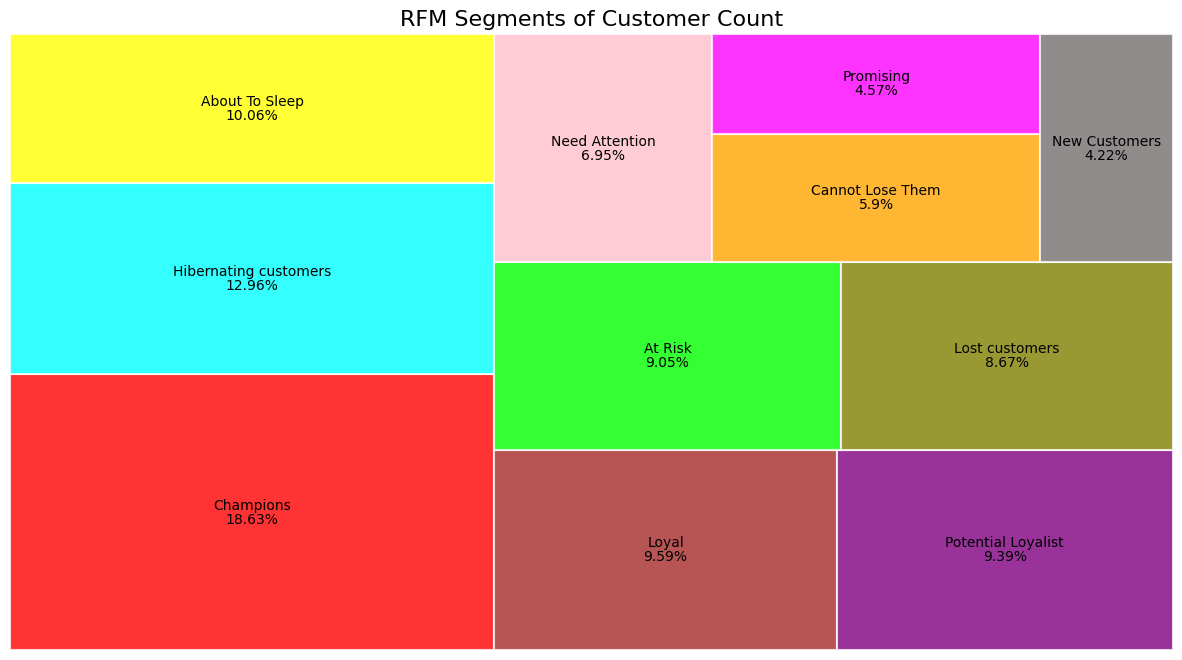

In [130]:
colors = ['#FF0000','#00FFFF','#FFFF00','#A52A2A','#800080','#00FF00','#808000','#FFC0CB','#FFA500','#FF00FF','#736F6E']
fig,ax = plt.subplots(1, figsize=(15,8))

squarify.plot(sizes=grp1["CountCus"]
              , label=grp1["Segment"]
              , value=[f'{x}%' for x in grp1["CountShare%"]]
              , alpha=.8
              , color=colors
              , bar_kwargs=dict(linewidth=1.5, edgecolor="white"))
plt.title("RFM Segments of Customer Count", fontsize=16)
plt.axis("off")
plt.show()

### **Distribution Recency**: Most of customers have orders recently (less than 50 days)
1. **Cannot Lose Them & Lost Customers** have no orders in nearly 1 year
2. **At Risk, Hibernating, About to Sleep** have no orders in 5-7 months
3. **else** have orders recently

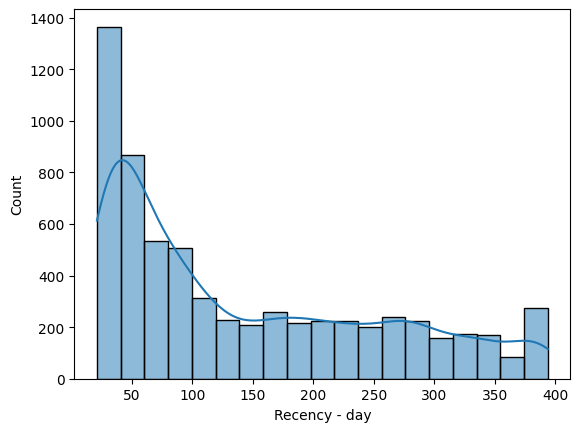

In [131]:
sns.histplot(data=seg_table["Recency"], kde=True)
plt.xlabel("Recency - day")

plt.show()

=> Most of customers have orders recently (less than 50 days)

=> We need to observe recency of each segment to get more insights

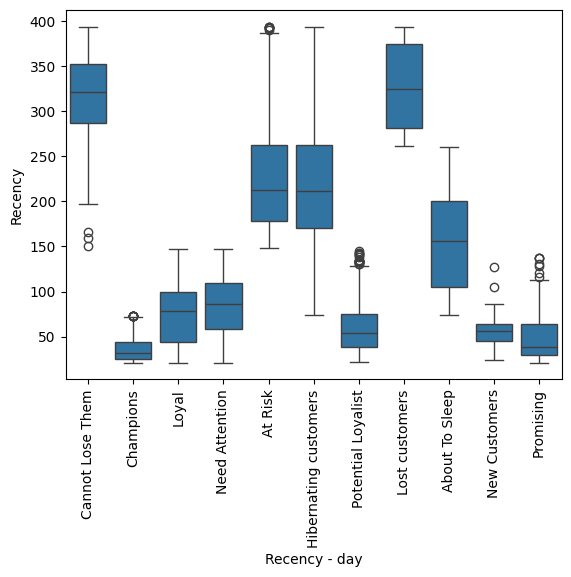

In [132]:
sns.boxplot(data=seg_table, x=seg_table["Segment"], y=seg_table["Recency"])
plt.xlabel("Recency - day")
plt.xticks(rotation=90)

plt.show()

=> 2 segments **Cannot Lose Them & Lost Customers** have no orders in nearly 1 year

=> 3 segments **At Risk, Hibernating, About to Sleep** have no orders in 5-7 months

=> **else** have orders recently

### **Distribution Frequency**: Most customers have frequency of buying goods less than 25 times
1. **Champions**: median 7 purchase, recent orders
2. **Cannot Lose Them, Lost Customer**: median 1 purchase, no orders in 1 year
3. **Hibernating, About To Sleep, At Risk**: median 1-2 purchase, no orders in 5-7 months
4. **New Customer, Potential Loyalist, Promising, Need Attention, Loyal**: median 1-3 purchase, no orders in 1-3 months


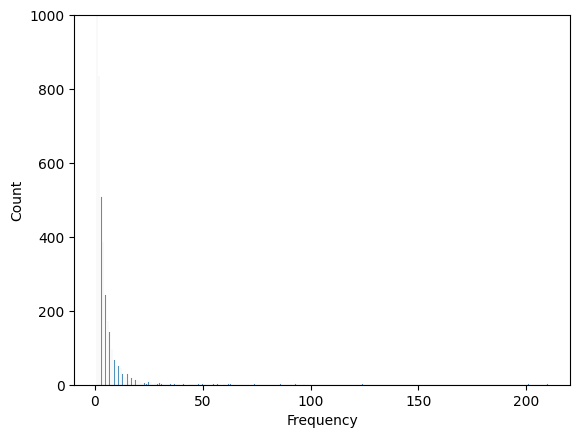

In [133]:
g = sns.histplot(data=seg_table["Frequency"], kde=False)
g.set(ylim=(0,1000))
plt.show()

=> Most customers have frequency of buying goods less than 25

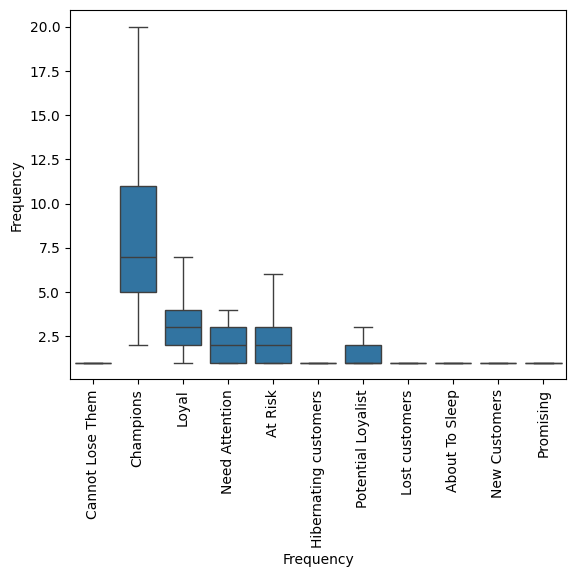

In [134]:
sns.boxplot(data=seg_table, x=seg_table["Segment"], y=seg_table["Frequency"],showfliers=False)
plt.xlabel("Frequency")
plt.xticks(rotation=90)

plt.show()

As predicted:
- **Champions** is segment having highest frequency 5-10 times
- **Loyal, Need Attention, At Risk, Potential Loyalist** have frequency around 1-5 times
- **else** have frequency = 1

In [135]:
# Scatter plot
pivot_count = seg_table.groupby('Segment').agg({"Frequency":"median"}).sort_values("Frequency",ascending=False).rename(columns={"Frequency":"MedFrequency"}).reset_index()
pivot_mone = seg_table.groupby("Segment").agg({"Recency":"median"}).sort_values("Recency",ascending=False).rename(columns={"Recency":"MedRecency"}).reset_index()
summary = pivot_count.merge(pivot_mone, on= "Segment", how ="left")
summary

,Segment,MedFrequency,MedRecency
0,Champions,7.0,32.0
1,Loyal,3.0,78.0
2,At Risk,2.0,213.0
3,Need Attention,2.0,86.0
4,About To Sleep,1.0,156.0
5,Cannot Lose Them,1.0,322.0
6,Hibernating customers,1.0,212.0
7,Lost customers,1.0,325.0
8,New Customers,1.0,56.0
9,Potential Loyalist,1.0,54.0


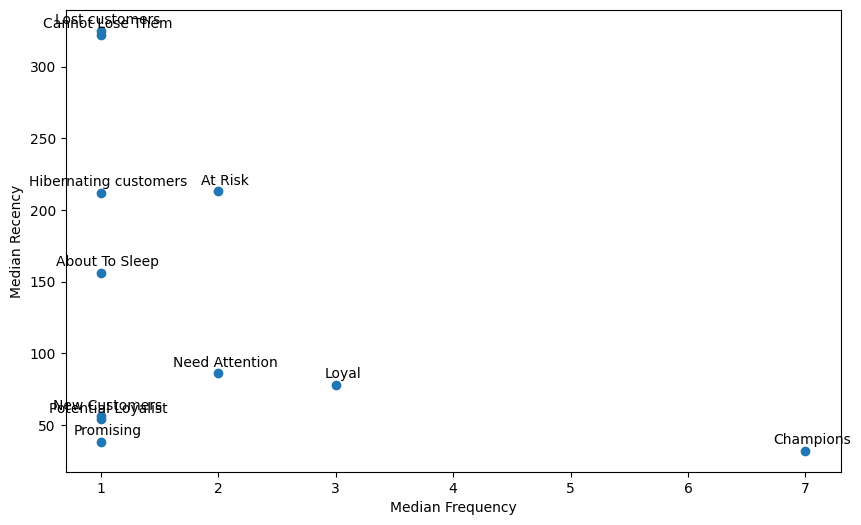

In [136]:
labels = list(summary["Segment"].values)
medfrequency = list(summary["MedFrequency"].values)
medrecency = list(summary["MedRecency"].values)

plt.figure(figsize=(10,6))
plt.scatter(medfrequency, medrecency)

for i in range(len(labels)):
    plt.annotate(labels[i], (medfrequency[i], medrecency[i]), textcoords="offset points", xytext=(5,5), ha='center')

plt.xlabel("Median Frequency")
plt.ylabel("Median Recency")
plt.show()

- **Champions**: 7 purchase, recent orders
- **Cannot Lose Them, Lost Customer**: 1 purchase, no orders in 1 year
- **Hibernating, About To Sleep, At Risk**: 1-2 purchase, no orders in 5-7 months
- **New Customer, Potential Loyalist, Promising, Need Attention, Loyal**: 1-3 purchase, no orders in 1-3 months

### **Distribution Monetary**: Total revenue of each customer is less than 10000 mostly
1. **Champions** have highest total revenue (2000-4000), contribute 60% total revenue
2. **Promising** have second highest (0-3000), contribute 5.5% total revenue
3. **Cannot Lose Them, Loyal, Need Attention, At Risk** have quite high revenue (1000-2000), contribute 5-9% total revenue
4. **else** spend least money, contribute less than 2% total revenue

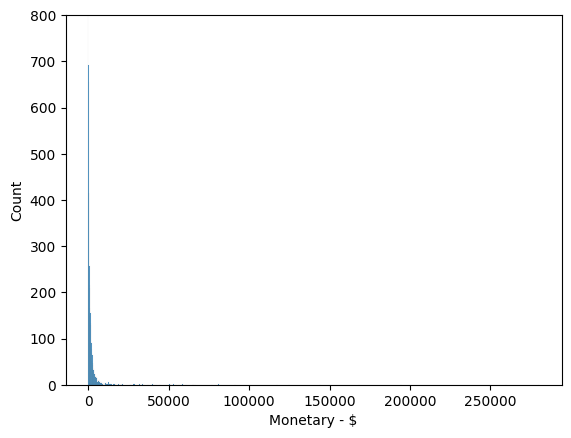

In [137]:
a = sns.histplot(data=seg_table["Monetary"],kde=False)
plt.xlabel("Monetary - $")
a.set(ylim=(0,800))
plt.show()

=> Total revenue of each customer is less than 10000 mostly

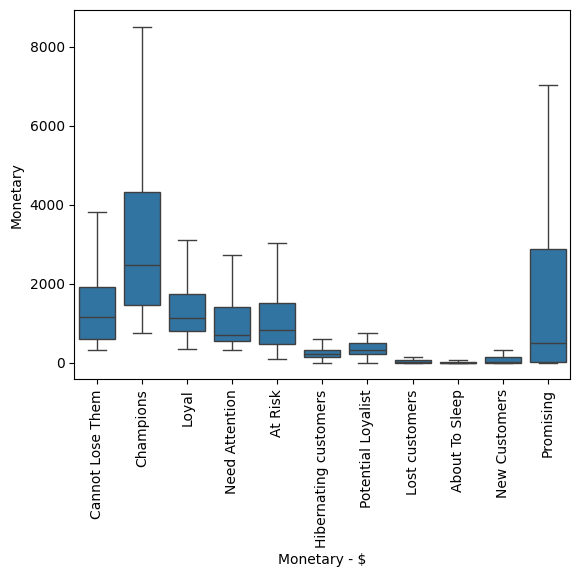

In [138]:
sns.boxplot(data=seg_table, x=seg_table["Segment"], y=seg_table["Monetary"],showfliers=False)
plt.xlabel("Monetary - $")
plt.xticks(rotation=90)

plt.show()

- **Champions** have highest total revenue (2000-4000)
- **Promising** have second highest (0-3000)
- **Cannot Lose Them, Loyal, Need Attention, At Risk** have quite high revenue (1000-2000)
- **else** spend least money

In [139]:
grp2 = seg_table.groupby("Segment").agg({"Monetary":"sum"}).reset_index().rename(columns={"Monetary":"MoneSum"}).sort_values("MoneSum",ascending=False)
grp2["MoneShare%"] = round((grp2["MoneSum"] / grp2["MoneSum"].sum()) * 100, 2)
grp2

,Segment,MoneSum,MoneShare%
3,Champions,6614477.080,62.01
6,Loyal,941903.961,8.83
2,Cannot Lose Them,762799.070,7.15
1,At Risk,756115.291,7.09
10,Promising,585801.501,5.49
7,Need Attention,487670.391,4.57
9,Potential Loyalist,220662.640,2.07
4,Hibernating customers,214775.650,2.01
0,About To Sleep,33793.020,0.32
5,Lost customers,28708.080,0.27


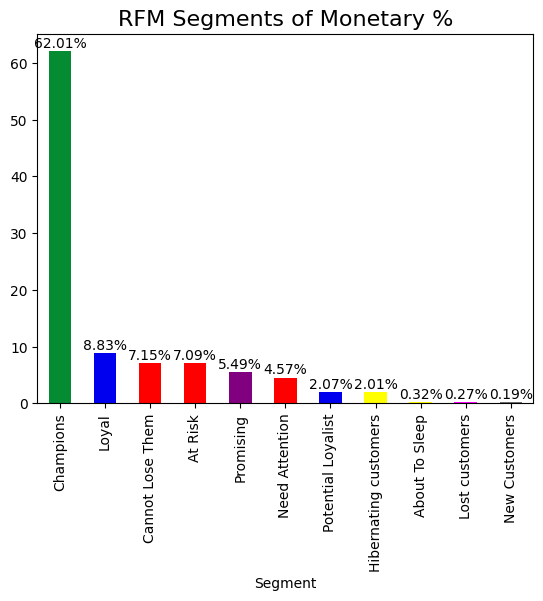

In [140]:
  #array: chứa vales cột MoneShare%
percent_vals = np.array(grp2["MoneShare%"])
colors = ['#058b32','#0000ee','#FF0000','#FF0000','#800080','#FF0000','#0000ee','#FFFF00','#FFFF00','#FF00FF','#736F6E']
  #bar plot
grp2.plot(kind="bar", x="Segment", y="MoneShare%",color=colors).get_legend().remove()
plt.title("RFM Segments of Monetary %", fontsize=16)
  #add data label
for i, value in enumerate(percent_vals):
    plt.text(i, value + 0.1, str(value)+'%', ha='center', va='bottom')

plt.show()

- **Champions** contributes the most revenue
- **Loyal, Cannot Lose Them, At Risk, Promising, Need Attention** contribute around 5-9% total revenue
- **else** contribute lower than 2%

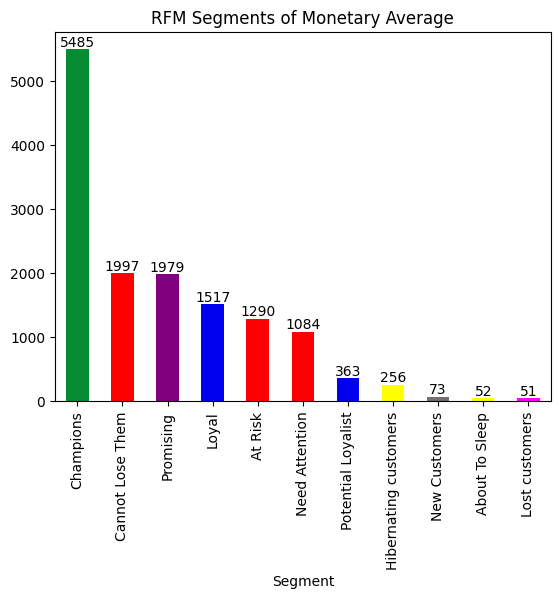

In [141]:
grp3 = seg_table.groupby("Segment").agg({"Monetary":"mean"}).sort_values("Monetary",ascending=False).rename(columns={"Monetary":"AvgMonetary"}).reset_index()
colors = ['#058b32','#FF0000','#800080','#0000ee','#FF0000','#FF0000','#0000ee','#FFFF00','#736F6E','#FFFF00','#FF00FF']
  #array: chứa cột AvgMonetary
avg_vals = np.array(grp3["AvgMonetary"])
  #barplot
grp3.plot(kind="bar", x="Segment",y="AvgMonetary",color=colors).get_legend().remove()
plt.title("RFM Segments of Monetary Average")
  #thêm data label
for i, value in enumerate(avg_vals):
    plt.text(i, value + 0.1, round(value), ha='center', va='bottom')
plt.show()

In [142]:
# Scatter plot
pivot_count = seg_table.groupby('Segment').agg({"CustomerID":"count"}).sort_values("CustomerID",ascending=False).rename(columns={"CustomerID":"CountCus"}).reset_index()
pivot_mone = seg_table.groupby("Segment").agg({"Monetary":"mean"}).sort_values("Monetary",ascending=False).rename(columns={"Monetary":"AvgMonetary"}).reset_index()
summary = pivot_count.merge(pivot_mone, on= "Segment", how ="left")
summary

,Segment,CountCus,AvgMonetary
0,Champions,1206,5484.641028
1,Hibernating customers,839,255.990048
2,About To Sleep,651,51.909401
3,Loyal,621,1516.753560
4,Potential Loyalist,608,362.931974
5,At Risk,586,1290.299131
6,Lost customers,561,51.173048
7,Need Attention,450,1083.711980
8,Cannot Lose Them,382,1996.856204
9,Promising,296,1979.059125


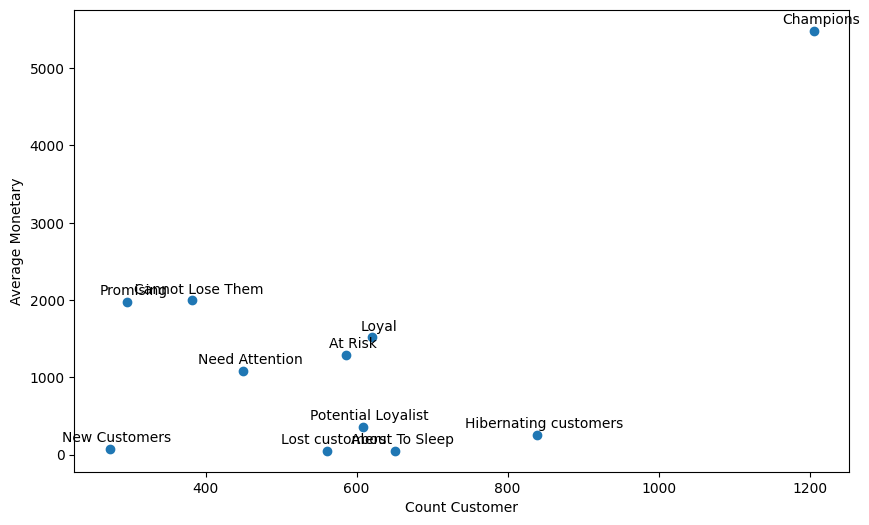

In [143]:
labels = list(summary["Segment"].values)
countcus = list(summary["CountCus"].values)
avgmone = list(summary["AvgMonetary"].values)

plt.figure(figsize=(10,6))
plt.scatter(countcus, avgmone)

for i in range(len(labels)):
    plt.annotate(labels[i], (countcus[i], avgmone[i]), textcoords="offset points", xytext=(5,5), ha='center')

plt.xlabel("Count Customer")
plt.ylabel("Average Monetary")
plt.show()

It is clear that:
- **Champions**: 1200 customers + highest avg spending (5000)
- **New Customers, Need Attention, At Risk, Loyal**: more customer, more spending
- **Potential Loyalist, Lost customer, About to Sleep, Hibernating**: 600-800 customers + low spending < 500
- **Promising, Cannot Lose Them**: 200-400 customers + quite high spending (2000)

### **Conclusion**
**QUANTITY & MONETARY**
1. **Champions**: 1200 customers, highest avg spending (5000), 60% total revenue
2. **New Customers, Need Attention, At Risk, Loyal**: more customer, more spending, 5-9% total revenue (except for New Customer - 2% total revenue)
3. **Potential Loyalist, Lost customer, About to Sleep, Hibernating**: 600-800 customers, low spending < 500, less than 2% total revenue
4. **Promising, Cannot Lose Them**: 200-400 customers, quite high spending (2000), 5-9% total revenue

**FREQUENCY & RECENCY**
1. **Champions**: median 7 purchases, recent orders
2. **Cannot Lose Them, Lost Customer**: median 1 purchases, no orders in 1 year
3. **Hibernating, About To Sleep, At Risk**: median 1-2 purchases, no orders in 5-7 months
4. **New Customer, Potential Loyalist, Promising, Need Attention, Loyal**: median 1-3 purchases, no orders in 1-3 months